## Prequisites Notebook

For the code in this notebook to work properly, the code below imports `numpy` and `matplotlib`. In addition, the numerical integration scheme for all SIR models is the 4th order Runge–Kutta (RK4), which is implemented in the same code block.

In [22]:
import handcalcs.render
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

def RK4(f, current_state: tuple, step_size: float = 0.01) -> float:
    k1 = step_size * f(*current_state)

    k2 = step_size * f(
        *[current_state[i] + k1 * 0.5 for i in range(len(current_state))]
    )
    k3 = step_size * f(
        *[current_state[i] + k2 * 0.5 for i in range(len(current_state))]
    )
    k4 = step_size * f(*[current_state[i] + k3 for i in range(len(current_state))])

    return (k1 + 2 * k2 + 2 * k3 + k4) / 6

## Implementation of The Naive SIR Model




The following code defines the differential equations described above as `baseSIR` class. Variants of the SIR model using `baseSIR` class are introduced later on. 

The initial states for $S$ and $R$ are derived using the initial proportions of infectands, `I0`. For the Naive SIR model, the following assumptions are made:
1. The population is known to stay constant, $S + I + R = 1$
2. There is no initial immunity, $R(0) = 0$ 

Therefore, the initial states may be defined as follows:
1. $S(0) = 1-I(0)$
2. $R(0) = 0$

The differential equations that govern the transition from one state to another, which are implemented straightforwardly as functions `dSdt()`, `dIdt()` in `baseSIR`, are given below:

$$
\frac{dS}{dt} = -\beta S I \\
\frac{dI}{dt} = \beta S I - \gamma I \\
\frac{dR}{dt} = \gamma I
$$

However, due to the assumptions of the Naive SIR model, $\frac{dR}{dt}$ does not have to be implemented in `baseSIR`, as $S + I + R = 1$ has to hold, and therefore $R$ can be found after using the updated states of $S$ and $I$.

To find the updated values of $S$ and $I$, the 4th order Runge–Kutta (RK4) scheme is used to numerically integrate the differential equations $\frac{dS}{dt}$ and $\frac{dI}{dt}$ in `numerical_integration()`. Given the current implementation of RK4 is quick, a default step size of 0.01 is picked for accuracy. `numerical_integration()` provides an array containing the values of S, I and R over time for each step.

In [23]:
class baseSIR:
    def __init__(self, beta: float, gamma: float, I0: float):
        """
        Initialize base SIR model with model parameters and initial conditions
        """
        self.beta = beta
        self.gamma = gamma

        self.S = 1 - I0
        self.I = I0
        self.R = 0

    def dSdt(self, S, I) -> float:
        """
        Differential equation for susceptible population.
        """
        return -self.beta * S * I

    def dIdt(self, S, I) -> float:
        """
        Differential equation for infected population.
        """
        return self.beta * S * I - self.gamma * I

    def update_step(self, dt=0.01):
        """
        Perform step update using the Runge–Kutta method.
        """
        self.S += RK4(self.dSdt, (self.S, self.I), step_size=dt)
        self.I += RK4(self.dIdt, (self.S, self.I), step_size=dt)
        self.R = 1 - self.S - self.I

    def numerical_integration(self, t: int, dt: float = 0.01):
        """Numerical Integration of the SIR model over time t using RK4 with step size dt.

        Args:
            t (int): Total time.
            dt (float, optional): Step size for RK4. Defaults to 0.01.

        Returns:
            Matrix of t, S, I, R

        """
        times = np.arange(0, t + dt, dt)
        S_values = [self.S]
        I_values = [self.I]
        R_values = [self.R]

        for _ in times[1:]:
            self.update_step(dt)
            S_values.append(self.S)
            I_values.append(self.I)
            R_values.append(self.R)

        return np.column_stack((times, S_values, I_values, R_values))

To verify that `baseSIR` works accordingly, the Naive SIR model is initialized with $\beta = 3$, $\gamma = 1$ and $I(0) = 0.01$ for 30 days. `matplotlib` is used to plot curves for $S$, $I$ and $R$ seen in the graph below.

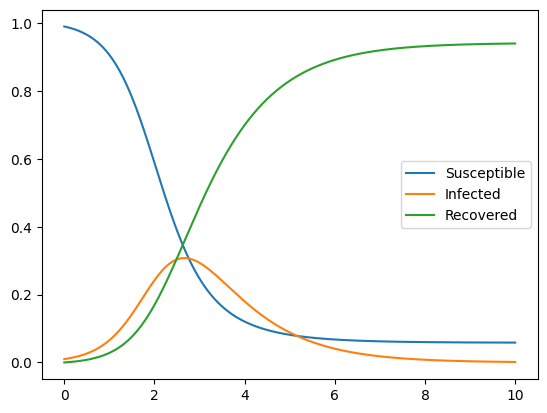

In [24]:
sir_model = baseSIR(beta=3, gamma=1, I0=0.01)
data = sir_model.numerical_integration(t=10, dt=0.01)

plt.plot(data[:, 0], data[:, 1], label='Susceptible')
plt.plot(data[:, 0], data[:, 2], label='Infected')
plt.plot(data[:, 0], data[:, 3], label='Recovered')
plt.legend()
plt.show()

### Observing Epidemics vs Extinction
In general, infectious diseases turn into epidemics when a peak in infectands is observed over time. Mathematically, this implies that, for the naive SIR model, that
1. Before the peak, the number of infectands rose, $\frac{dI}{dt} > 0$
2. Peaked, meaning that the number of infectands has attained its maximum, $\frac{dI}{dt} = 0$.
3. After the peak, the number of infectands decreases, $\frac{dI}{dt} < 0$

In order to investigate what parameters determine this chain of events, phase plots are created for different values of $I(0)$ through `plot_single_phase_diagram()`  

In [25]:
def plot_all_phase_diagrams(model_class, **model_kwargs):
    # Generate beta and gamma values
    beta_values = np.linspace(0.25, 1, 5)
    gamma_values = np.linspace(0.25, 1, 5)
    I0_values = np.linspace(0.05, 1, 10)

    # Define epidemic and extinction combinations
    epidemic_combinations = [
        (beta, gamma)
        for beta in beta_values
        for gamma in gamma_values
        if beta / gamma > 1
    ]
    extinction_combinations = [
        (beta, gamma)
        for beta in beta_values
        for gamma in gamma_values
        if beta / gamma < 1
    ]

    # Create a figure with 6 subplots (2 rows and 3 columns)
    plt.figure(figsize=(18, 12))

    # Plot the extinction phase diagrams (R0 < 1) with different I0 values (top row)
    # Pick the first 3 pairs
    for i, (beta, gamma) in enumerate(extinction_combinations[:3]):
        plot_single_phase_diagram(
            model_class,
            beta,
            gamma,
            I0_values,
            f"Extinction\nβ = {beta:.2f}, γ = {gamma:.2f}",
            i + 1,
            **model_kwargs,
        )

    # Plot the epidemic phase diagrams (R0 > 1) with different I0 values (bottom row)
    # Pick the first 3 pairs
    for i, (beta, gamma) in enumerate(epidemic_combinations[:3]):
        plot_single_phase_diagram(
            model_class,
            beta,
            gamma,
            I0_values,
            f"Epidemic\nβ = {beta:.2f}, γ = {gamma:.2f}",
            i + 4,
            **model_kwargs,
        )

    # Add a main title for the figure
    plt.suptitle("Phase Diagrams for Different β and γ Values", fontsize=16)

    # Adjust layout to make room for the main title and prevent overlapping
    plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)

    # Show the plots
    plt.show()

The following conclusion is observed from the phase plots:

* When $\frac{\beta}{\gamma} > 1$, for all possible initial states for $I(0)$ flow to 0 without increasing over time. 
* When $\frac{\beta}{\gamma} < 1$, although some extreme initial states for $I(0)$ flow to 0 without increasing, for more reasonable states for $I(0)$, an intermediate peak is observed.

Therefore, $\frac{\beta}{\gamma}$ seems to determine whether an infectious disease becomes an epidemic.

KeyboardInterrupt: 

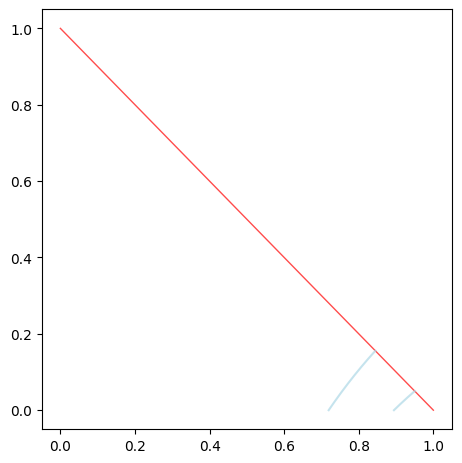

In [26]:
plot_all_phase_diagrams(baseSIR)

### Fitting the Naive SIR model


To fit the Naive SIR model to the Influenza outbreak situation, a custom optimizer is created for `baseSIR` and their variants.

 `solverSIR` takes any loss function, `loss_fun()`, and optimizes a set of parameters to fit to an array of the observed proportion of infectands, `obsS`. In order for solverSIR to work for any variant of `baseSIR`, a distinction is made between the SIR parameters to optimize, `init_params` and `params`, and SIR parameters to hold constant, `**kwargs`.

To compute the gradient, the forward finite difference method is used. The value of the loss function, $\mathcal{L}$, is found for a small, finite perbutation, $\epsilon$, of each parameter.

To update the values of each parameter, a variant of gradient descent, AdaGrad is implemented. AdaGrad allows for an adaptive learning rate for each parameter.

In [27]:

class solverSIR:
    def __init__(self, SIR, loss_fn, init_params, **kwargs):
        self.classSIR = SIR
        self.loss_fn = loss_fn
        self.params = np.array(init_params)
        self.kwargs = kwargs

    def computeLoss(self, params, obsS):
        time = len(obsS) 

        model_t = self.classSIR(*params, **self.kwargs).numerical_integration(time-1)

        fitS_t = model_t[np.isin(model_t[:, 0], np.arange(0, time+1)), 2]

        loss_t = self.loss_fn(obsS, fitS_t)
        return loss_t

    def computeGrad(self, obsS, params, epsilon=1e-6):
        grad = np.zeros_like(params)

        loss_t = self.computeLoss(params, obsS)

        for i, _ in enumerate(params):
            params[i] += epsilon

            loss_dt = self.computeLoss(params, obsS)

            grad[i] = (loss_dt - loss_t) / epsilon

            params[i] -= epsilon  # Restore the original parameter

        return grad
    
    def optimize(self, obsS, learning_rate=0.01, max_iterations=1000, epsilon=1e-8):
        params = np.array(self.params, dtype = float) 
        
        lowest_loss = float('inf')
        best_params = params.copy()

        # Implement Adagrad
        accumulated_grad_squares = np.zeros_like(params)

        for iteration in range(max_iterations):
            grad = self.computeGrad(obsS, params)
            
            params -= learning_rate * grad

        
            accumulated_grad_squares += grad ** 2
            
            adjusted_grad = grad / (np.sqrt(accumulated_grad_squares) + epsilon)
            params -= learning_rate * adjusted_grad

            current_loss = self.computeLoss(params, obsS)

            # Update previous loss
            prev_loss = current_loss

       
            if current_loss < lowest_loss:
                lowest_loss = current_loss
                best_params = params.copy()


            if iteration % 100 == 0:
                print(f'Iteration {iteration}: Lowest Loss = {lowest_loss}, Best Parameters = {best_params}')

        
        return params, current_loss
    

    def plot_fitvsobs(self, obsS):
        time = len(obsS)

        # Create an instance of the model with the final optimized parameters
        model_instance = self.classSIR(*self.params, **self.kwargs)
        model_t = model_instance.numerical_integration(time-1)

        # Plot observed vs fitted values
        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(0, time), obsS, 'o', label='Observed Infected')
        plt.plot(model_t[:,0], model_t[:,2], '-', label='Fitted Infected')
        plt.xlabel('Time')
        plt.ylabel('Infected Population')
        plt.title('Fitted vs Observed Susceptible Population')
        plt.legend()
        plt.grid(True)
        plt.show()



In [29]:
def MSE(estimated_data, observed_data):
    return np.mean((observed_data - estimated_data) ** 2)

Iteration 0: Lowest Loss = 0.0004790469309358187, Best Parameters = [1.6564402  0.44043995]
Iteration 100: Lowest Loss = 0.00046346472188829466, Best Parameters = [1.6652335  0.44993772]
Iteration 200: Lowest Loss = 0.00046346472188829466, Best Parameters = [1.6652335  0.44993772]
Iteration 300: Lowest Loss = 0.00046346472188829466, Best Parameters = [1.6652335  0.44993772]
Iteration 400: Lowest Loss = 0.00046346472188829466, Best Parameters = [1.6652335  0.44993772]
Iteration 500: Lowest Loss = 0.00046346472188829466, Best Parameters = [1.6652335  0.44993772]
Iteration 600: Lowest Loss = 0.00046346472188829466, Best Parameters = [1.6652335  0.44993772]
Iteration 700: Lowest Loss = 0.00046346472188829466, Best Parameters = [1.6652335  0.44993772]
Iteration 800: Lowest Loss = 0.00046346472188829466, Best Parameters = [1.6652335  0.44993772]
Iteration 900: Lowest Loss = 0.00046346472188829466, Best Parameters = [1.6652335  0.44993772]


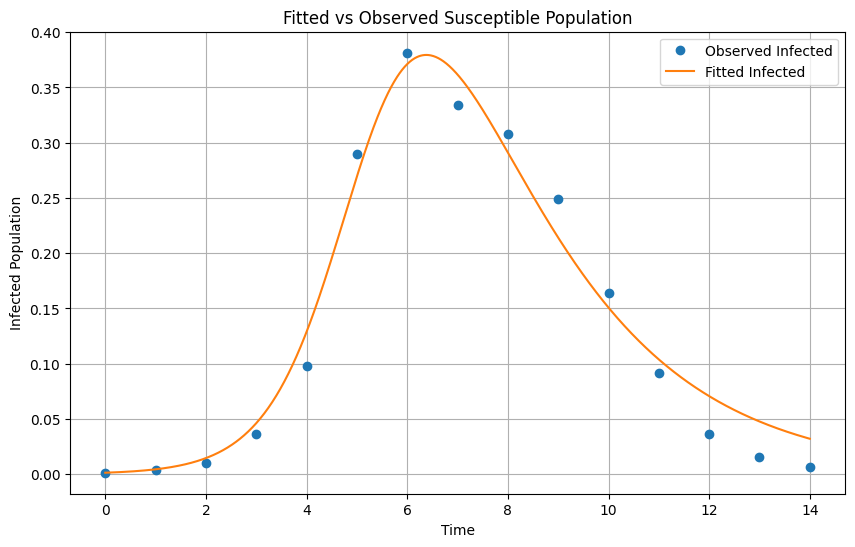

In [30]:
school_data = np.array([1, 3, 8, 28, 75, 221, 291, 255,
                  235, 190, 125, 70, 28, 12, 5]) / 763 
solver = solverSIR(baseSIR, MSE, [1.66523459, 0.44993837], I0 = 1/763)
solver.optimize(school_data, learning_rate=0.01, max_iterations=1000)
solver.plot_fitvsobs(school_data)